# Startup Lending Model (Probabalistic Loan Pricing)

## Setup

Setup for the later calculations are here. The necessary packages are imported.

In [1]:
!pip install numpy_financial -q
!pip install yfinance -q


In [2]:
from dataclasses import dataclass
import pandas as pd
%matplotlib inline
import numpy as np #supports large arrays
import numpy_financial as npf
import matplotlib.pyplot as plt #charts
from tqdm.notebook import tqdm #progress bar
import random #pseudo-random number generator
import yfinance as yf #gets treasury bill rate for determining discount rate



/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


## Inputs

All of the inputs for the model are defined here. A class is constructed to manage the data, and an instance of the class containing the default inputs is created.

In [ ]:
@dataclass
class ModelInputs:
    price_machine: float
    loan_life: int
    initial_default: float
    default_decay: float
    final_default: float
    recovery_rate: float
    interest_rates: float
    num_iterations: int = 1000


# setting defaults
# Change the price of loan, default decay, final default, and recovery rate here. Oppurtunity to chaange interest rates and loan life later.
model_data = ModelInputs(
    price_machine = 1000000, #Set the price of loan
    loan_life = 5,
    initial_default = 0.2, #Set the initial rate of default
    default_decay = 0.9, #Set the rate that chance of default decays
    final_default = 0.4, #Set the chance of default when balloon payment becomes due
    recovery_rate = 0.4, #Set the amount of loan principle that is recovered after default. Model assumes two years of no cash flows after default
    interest_rates = 0.30,
)

model_data # prints initial data for testing

ModelInputs(price_machine=1000000, loan_life=55, initial_default=0.2, default_decay=0.9, final_default=0.4, recovery_rate=0.4, interest_rates=0.3, num_iterations=1000)

## Functions

The necessary functions for calculating cash flows, default probability, and
default year.

Also contains the **main simulation function**.

In [ ]:
def calculate_cash_flows(data, interest_rate, default_year):
  cash_flows = [-data.price_machine] # initial outflow for the bank
  for year in range(1, data.loan_life):
    if year < default_year:
      cash_flows.append(data.price_machine * interest_rate) #each years payment
    elif year == default_year:
        cash_flows.append(0) #returns nothing
        break #exits the loop

  #options where default does not occur within loan life
  if default_year <= data.loan_life:
    cash_flows.extend([0,0]) #adds two years of no cash flows for the bankruptcy period. Necessary for IRR calculation
    cash_flows.append(data.recovery_rate * data.price_machine) #this is balloon payment

  else:
    cash_flows.append(data.price_machine * (1 + interest_rate)) #the balloon payment in final year if no default

  return cash_flows

example_cash_flows = calculate_cash_flows(model_data, 0.35, 4)

example_cash_flows #Prints a sample of cash flows for testing

[-1000000, 350000.0, 350000.0, 350000.0, 0, 0, 0, 400000.0]

In [ ]:
def default_probability_at_year(data, year):
  """
  Calculates probability of default at a given year
  """

  if year ==1:
    return data.initial_default
  elif year < data.loan_life:
    return data.initial_default * (data.default_decay ** (year -1))
  else:
    return data.final_default


def get_random_default_year(data): #introduced internal randomness. Most complex part of funciton
  """
  Returns a random year of default
  """
  probabilities = [default_probability_at_year(data, year) for year in range(1, data.loan_life + 1)]
  probabilities.append(data.final_default) #final year default probability
  cumulative_prob = np.cumsum(probabilities) #mock cdf
  rand_val = random.uniform(0,1) #generates random float
  #for loop to work through each year of loan
  for year, cum_prob in enumerate(cumulative_prob, 1): #enumerate takes two values and compares them. 1 is year and 2 is cumulative probability
      if rand_val <= cum_prob: #if random var is less than cum_prob of default
        return int(year) #if the random variable is less than cumulative probability of default. This finds what year default happens in.
  return int(data.loan_life) # indicates no default



In [ ]:
def simulate_loan_scenarios(data, interest_rates, loan_lives):
  """
  Runs a simulation that calculate IRR for each combination of interest rates and loan lives
  """
  scenarios_results = [] #initialize scenerio results
  total_iterations = len(interest_rates) * len(loan_lives) * data.num_iterations #this allows you to change parameters and be more fluid. If you didn't want to change parameters you could just set total iterations to 27000
  with tqdm(total=total_iterations, desc="Sumulating Loan Scenarios") as pbar: #creates prorgress bar
    for rate in interest_rates:
      for life in loan_lives:
        irrs = []
        data.loan_life = life #updates loan life per scenario
        for iteration in range(data.num_iterations):
          data.initial_default = np.clip(np.random.normal(0.2, 0.05), 0, 1) #uses a normal distribution to determine probability of default
          default_year = get_random_default_year(data)
          cash_flows = calculate_cash_flows(data, rate, default_year)
          try:
            irr = npf.irr(cash_flows)
            irrs.append(irr)
          except:
            pass # skip iterations where IRR cannot be calculated
          finally:
            pbar.update(1)

          #Creates data frame for later use
          scenarios_results.append({
              'Interest Rate': rate,
              'Loan Life': int(life),
              'Expected IRR': irr,
          })
  return pd.DataFrame(scenarios_results)


## Inputs and Running the Simulation

Run the simulation by entering a list of interest rates and list of loan lives seperated by commas.

You may change the number of iterations if desired in the next cell. Low numbers will run faster. High numbers will be more accurate. Minimum of 1000 is recommended.


In [ ]:
def get_interest_rates():
    rates_str = input("Enter interest rates separated by commas (e.g., 0.30, 0.35, 0.40): ")
    if not rates_str:
      return [0.30, 0.35, 0.40]
    else:
      return [float(rate) for rate in rates_str.split(',')]

def get_loan_lives():
    lives_str = input("Enter loan lives separated by commas (e.g., 5, 10, 20): ")
    if not lives_str:
        return [5, 10, 20]
    else:
      return [int(life) for life in lives_str.split(',')]

# Get user input for interest rates and loan lives

interest_rates = get_interest_rates()
loan_lives = get_loan_lives()

Enter interest rates separated by commas (e.g., 0.30, 0.35, 0.40): 
Enter loan lives separated by commas (e.g., 5, 10, 20): 


In [ ]:
# Adjust the number of iterations. More iterations gives more accurate prediction.

model_data.num_iterations = 1000 #reduce iterations for quicker execution


In [ ]:
#Gets the five year treasury yield rate from yahoo finance
five_year_treasury_yield = yf.download('^TNX', period='1mo')['Close'].iloc[-1]
threshold = five_year_treasury_yield / 100 #calculate rate to be used for recommendation

[*********************100%%**********************]  1 of 1 completed


In [ ]:
print(f"The 5 year treasury yield is: {five_year_treasury_yield:.2f}")

The 5 year treasury yield is: 4.28


## Results

Shows the simulation **results** and visualizations.

In [ ]:
df_discrete = simulate_loan_scenarios(model_data, interest_rates, loan_lives) #runs the main simulation for all scenerios

def calculate_average_irr(scenarios_results):
    """
    Calculate the average IRR for each scenario and return a DataFrame.
    """
    avg_irr_results = []

    # Group the scenarios by 'Interest Rate' and 'Loan Life'
    grouped_scenarios = pd.DataFrame(scenarios_results).groupby(['Interest Rate', 'Loan Life'])

    # Calculate average IRR for each group
    for (interest_rate, loan_life), group_data in grouped_scenarios:
        average_irr = group_data['Expected IRR'].mean()
        above_threshold = "Yes" if average_irr > threshold else "No"  # Determines if IRR is greater than 5-year treasury yield
        avg_irr_results.append({
            'Interest Rate': interest_rate,
            'Loan Life': loan_life,
            'Average IRR': average_irr,
            'Issue Loan': above_threshold,
        })

    avg_irr_df = pd.DataFrame(avg_irr_results)

    # Apply conditional formatting to 'Average IRR' column
    avg_irr_df_styled = avg_irr_df.style.background_gradient(cmap='RdYlGn', subset=['Average IRR'])

    avg_irr_df_styled = avg_irr_df_styled.applymap(lambda x: 'font-weight: bold' if x == 'Yes' else '', subset=['Issue Loan'])

    return avg_irr_df, avg_irr_df_styled # returns stylized and unstylized data frame(for use in chart)

# Create the stylized data frame:
average_irr_df, average_irr_df_styled = calculate_average_irr(df_discrete)

average_irr_df_styled

Sumulating Loan Scenarios:   0%|          | 0/9000 [00:00<?, ?it/s]

,Interest Rate,Loan Life,Average IRR,Issue Loan
0,0.300000,5,0.015419,No
1,0.300000,10,0.010367,No
2,0.300000,20,0.007702,No
3,0.350000,5,0.041981,No
4,0.350000,10,0.049794,Yes
5,0.350000,20,0.033283,No
6,0.400000,5,0.070507,Yes
7,0.400000,10,0.068506,Yes
8,0.400000,20,0.080666,Yes


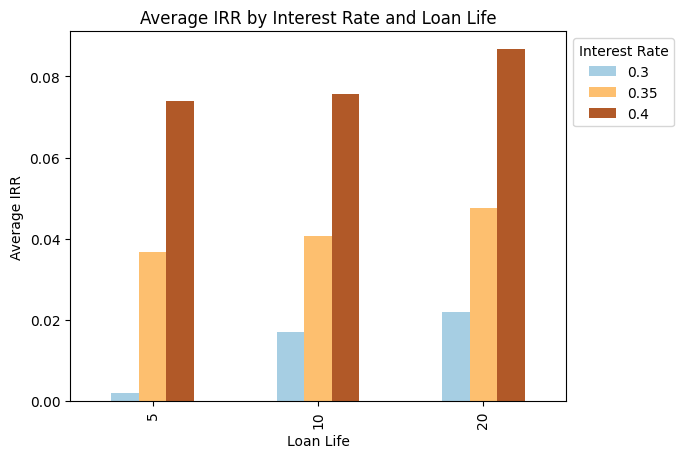

In [ ]:
# Create clustered bar chart
def create_clustered_bar_chart(dataframe):
    # Sort the columns by 'Loan Life' in ascending order
    sorted_columns = sorted(dataframe['Interest Rate'].unique())

    # Pivot the DataFrame for better plotting
    pivot_df = dataframe.pivot(index='Loan Life', columns='Interest Rate', values='Average IRR')

    # Reorder the columns based on the sorted order
    pivot_df = pivot_df[sorted_columns]

    ax = pivot_df.plot(
        kind='bar',
        title='Average IRR by Interest Rate and Loan Life',
        colormap='Paired',
        xlabel='Loan Life',
        ylabel='Average IRR',
    )

    ax.legend(title='Interest Rate', bbox_to_anchor=(1, 1))
    plt.show()

create_clustered_bar_chart(average_irr_df)


## Recommendation

The bank should only make the loan when the IRR is greater than their discount rate. This model uses the 5 year treasury yield as a default discount rate. The bank should only issue loans when the "issue loans" column in the above table indicates "Yes."

In general, loans with a longer life and loans with a higher interest rate have greater IRR
